Image classification code 1 [here](https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/)


Image classification code 2 [here](https://www.kaggle.com/vincee/intel-image-classification-cnn-keras)

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Removing the original dataset forlder to get more free memory
import shutil
path='dataset/'
shutil.rmtree(path, ignore_errors=False, onerror=None)

In [3]:
!mkdir dataset
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/MultiClass_Dataset.rar", outdir="/content/dataset")

patool: Extracting /content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/MultiClass_Dataset.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/MultiClass_Dataset.rar"
patool:     with cwd='/content/dataset'
patool: ... /content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/MultiClass_Dataset.rar extracted to `/content/dataset'.


'/content/dataset'

**Import Packages**

In [4]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [5]:
class_names = ['Normal', 'Mild', 'Moderate', 'Severe']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
print(nb_classes)
IMAGE_SIZE = (300, 300)
print('The image size is:', IMAGE_SIZE)

4
The image size is: (300, 300)


**Loading the Data**

We have to write a load_data function that load the images and the labels from the folder.

In [6]:
def load_data():
        
    datasets = ['/content/dataset/training', '/content/dataset/testing']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
(train_images, train_labels), (test_images, test_labels) = load_data()

                

  4%|▎         | 45/1240 [00:00<00:02, 445.85it/s]

Loading /content/dataset/training


 39%|███▊      | 54/140 [00:00<00:00, 537.52it/s]

Loading /content/dataset/testing


100%|██████████| 140/140 [00:00<00:00, 512.67it/s]


**Let's explore the dataset**

We can ask ourselves:

1.   How many training and testing examples do we have ?
2.   What is the size of the images ?

In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 4789
Number of testing examples: 560
Each image is of size: (300, 300)


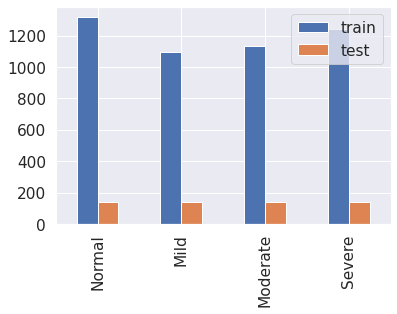

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

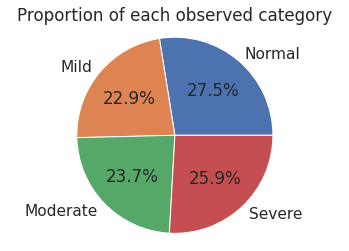

In [10]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [11]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

**Visualize the data** 

We can display a random image from the training set.

In [12]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

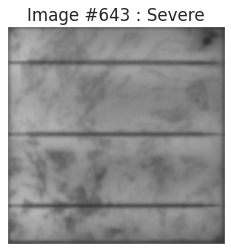

In [12]:
display_random_image(class_names, train_images, train_labels)


We can also display the first 25 images from the training set directly with a loop to get a better view

In [13]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

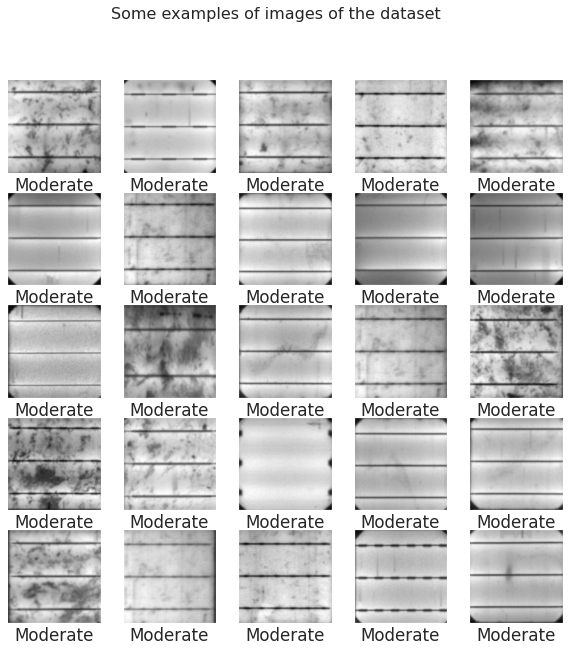

In [ ]:
display_examples(class_names, train_images, train_labels)


**Beginner: Simple Model Creation**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (300, 300, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])
model.summary()

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (300, 300, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

In [16]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(train_images, train_labels, batch_size=100, epochs=20, validation_split = 0.2)


Epoch 1/20
39/39 [==============================] - 14s 349ms/step - loss: 0.0748 - accuracy: 0.9749 - val_loss: 1.8405 - val_accuracy: 0.3518
Epoch 2/20
39/39 [==============================] - 14s 349ms/step - loss: 0.0732 - accuracy: 0.9731 - val_loss: 1.9055 - val_accuracy: 0.2829
Epoch 3/20
39/39 [==============================] - 13s 343ms/step - loss: 0.0741 - accuracy: 0.9742 - val_loss: 1.6790 - val_accuracy: 0.4937
Epoch 4/20
39/39 [==============================] - 14s 348ms/step - loss: 0.0511 - accuracy: 0.9796 - val_loss: 1.5953 - val_accuracy: 0.5282
Epoch 5/20
39/39 [==============================] - 13s 344ms/step - loss: 0.0656 - accuracy: 0.9768 - val_loss: 2.7237 - val_accuracy: 0.3017
Epoch 6/20
39/39 [==============================] - 14s 347ms/step - loss: 0.0616 - accuracy: 0.9781 - val_loss: 1.8014 - val_accuracy: 0.4603
Epoch 7/20
39/39 [==============================] - 13s 346ms/step - loss: 0.0463 - accuracy: 0.9825 - val_loss: 1.9935 - val_accuracy: 0.3727

In [29]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

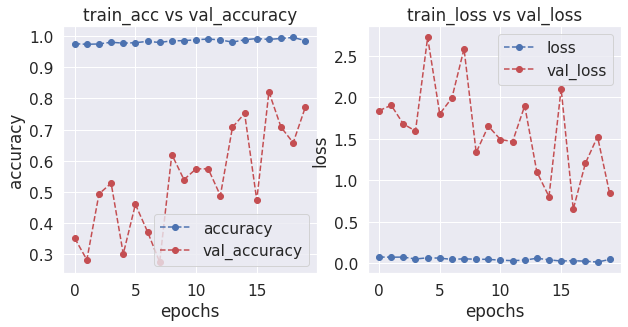

In [30]:
plot_accuracy_loss(history)


In [31]:
model.save_weights("Last_CNN_Model.h5")

In [32]:
# copy the model to mydrive
!cp '/content/Last_CNN_Model.h5' '/content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/Last_CNN_Model.h5'

In [33]:
model.load_weights("Last_CNN_Model.h5")

In [34]:
test_loss = model.evaluate(test_images, test_labels)


18/18 [==============================] - 1s 47ms/step - loss: 0.3446 - accuracy: 0.9161


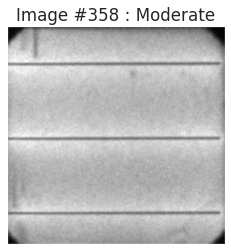

In [35]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

**Error analysis**

We can try to understand on which kind of images the classifier has trouble.

In [26]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

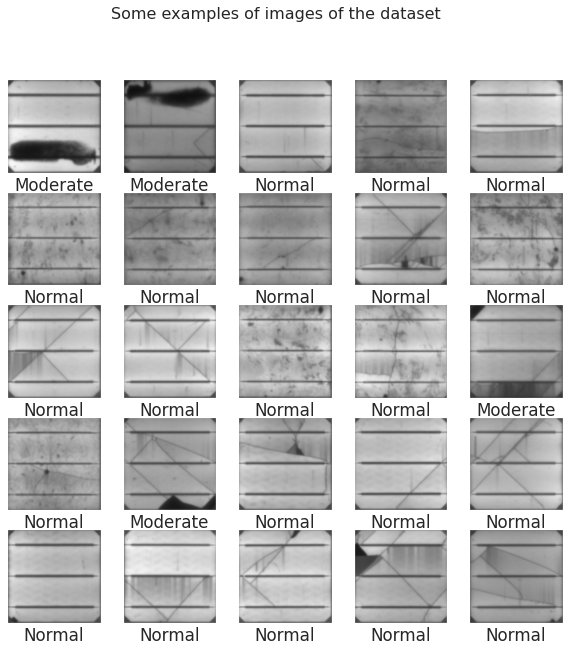

In [26]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)


In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
accuracy_score(test_labels, pred_labels)

0.9160714285714285

In [37]:
Recall_Score = recall_score(test_labels, pred_labels,average='weighted') 
Recall_Score

0.9160714285714285

In [38]:
Precision_Score = precision_score(test_labels, pred_labels,average='weighted') 
Precision_Score

0.9155931324187175

In [39]:
F1_score = 2*((Recall_Score * Precision_Score)/(Recall_Score + Precision_Score))
F1_score

0.9158322180471733

In [40]:
matrix = confusion_matrix(test_labels, pred_labels)
matrix

array([[140,   0,   0,   0],
       [  4, 114,   1,  21],
       [  0,   0, 140,   0],
       [  4,   9,   8, 119]])

In [41]:
print(classification_report(test_labels, pred_labels))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       140
           1       0.93      0.81      0.87       140
           2       0.94      1.00      0.97       140
           3       0.85      0.85      0.85       140

    accuracy                           0.92       560
   macro avg       0.92      0.92      0.91       560
weighted avg       0.92      0.92      0.91       560



In [47]:
#Prepared code that is taken from SKLearn Website, Creates Confusion Matrix
import itertools    

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[140   0   0   0]
 [  4 114   1  21]
 [  0   0 140   0]
 [  4   9   8 119]]


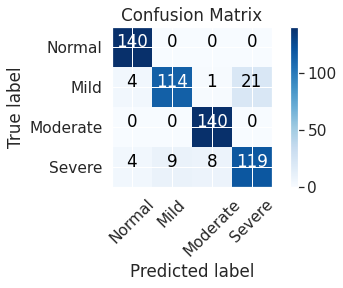

In [48]:
cm_plot_labels = class_names
plot_confusion_matrix(matrix,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix')

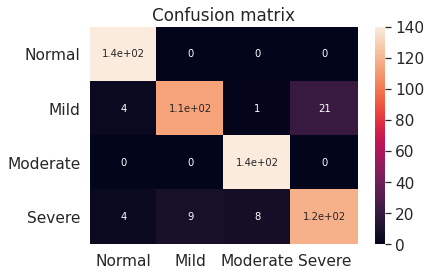

In [44]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()